In [47]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs, make_circles, make_moons
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split,cross_val_score

In [48]:
#Container class for the model used for SMO

class SMO:
    def __init__(self, X, y, C, kernel, alpha, b, errors):
        self.X = X                
        self.y = y               
        self.C = C               
        self.kernel = kernel     
        self.alpha = alpha       
        self.b = b               
        self.errors = errors     
        self._obj = []           
        self.m = len(self.X)     

In [49]:
#Linear Kernel K(xi,xj)=xi·xj

def kernel(x, y, b=0):
    return np.dot(x,y.T) + b 

In [50]:
#Objective function for optimisation
"""Input :
    `alpha`: vector of Lagrangian multipliers
    `target`: vector of class labels (-1 or 1) for training data
    `kernel`: kernel function
    `X_train`: training data for model.
    
    Output :
    SVM objective function based in the input model"""

def objective(alpha, target, kernel, X_train):
    return np.sum(alpha) - 0.5 * np.sum((target[:, None] * target[None, :]) * kernel(X_train, X_train) * (alpha[:, None] * alpha[None, :]))

In [51]:
#Decision Function which decides the label
"""Applies the SVM decision function to the input feature vectors in `x_test`."""

def decision(alpha, target, kernel, X_train, x_test, b):
    result = np.dot((alpha * target) ,kernel(X_train, x_test)) - b
    return result

In [52]:
#Train function
"""This function implements selection of the first  α to optimize via
   the first choice heuristic and passes this value to examine_example().
   The train() function uses a while loop to iterate through the  α  values
   to return the optimized  α  vector"""

def train(model):
    
    numChanged = 0
    examineAll = 1

    while(numChanged > 0) or (examineAll):
        numChanged = 0
        if examineAll:
            # loop over all training examples
            for i in range(model.alpha.shape[0]):
                examine_result, model = examine_example(i, model)
                numChanged += examine_result
                if examine_result:
                    obj_result = objective(model.alpha, model.y, model.kernel, model.X)
                    model._obj.append(obj_result)
        else:
            # loop over examples where alphas are not already at their limits
            for i in np.where((model.alpha != 0) & (model.alpha != model.C))[0]:
                examine_result, model = examine_example(i, model)
                numChanged += examine_result
                if examine_result:
                    obj_result = objective(model.alpha, model.y, model.kernel, model.X)
                    model._obj.append(obj_result)
        if examineAll == 1:
            examineAll = 0
        elif numChanged == 0:
            examineAll = 1
        
    return model

In [53]:
#Train function
"""This function implements selection of the first  α to optimize via
   the first choice heuristic and passes this value to examine_example().
   The train() function uses a while loop to iterate through the  α  values
   to return the optimized  α  vector"""

def train(model):
    
    numChanged = 0
    examineAll = 1

    while(numChanged > 0) or (examineAll):
        numChanged = 0
        if examineAll:
            # loop over all training examples
            for i in range(model.alpha.shape[0]):
                examine_result, model = examine_example(i, model)
                numChanged += examine_result
                if examine_result:
                    obj_result = objective(model.alpha, model.y, model.kernel, model.X)
                    model._obj.append(obj_result)
        else:
            # loop over examples where alphas are not already at their limits
            for i in np.where((model.alpha != 0) & (model.alpha != model.C))[0]:
                examine_result, model = examine_example(i, model)
                numChanged += examine_result
                if examine_result:
                    obj_result = objective(model.alpha, model.y, model.kernel, model.X)
                    model._obj.append(obj_result)
        if examineAll == 1:
            examineAll = 0
        elif numChanged == 0:
            examineAll = 1
        
    return model

In [54]:
#Examine function
"""Then examine_example() implements the second choice heuristic
to choose the second  α  to optimize, and passes the index of both
α  values to take_step()"""

def examine_example(i2, model):
    y2 = model.y[i2]
    alph2 = model.alpha[i2]
    E2 = model.errors[i2]
    r2 = E2 * y2

    # Proceed if error is within specified tolerance (tol)
    if ((r2 < -tol and alph2 < model.C) or (r2 > tol and alph2 > 0)):
        
        if len(model.alpha[(model.alpha != 0) & (model.alpha != model.C)]) > 1:
            # Use 2nd choice heuristic is choose max difference in error
            if model.errors[i2] > 0:
                i1 = np.argmin(model.errors)
            elif model.errors[i2] <= 0:
                i1 = np.argmax(model.errors)
            step_result, model = take_step(i1, i2, model)
            if step_result:
                return 1, model
            
        # Loop through non-zero and non-C alphas, starting at a random point
        for i1 in np.roll(np.where((model.alpha != 0) & (model.alpha != model.C))[0],
                          np.random.choice(np.arange(model.m))):
            step_result, model = take_step(i1, i2, model)
            if step_result:
                return 1, model
        
        # Loop through all alphas, starting at a random point
        for i1 in np.roll(np.arange(model.m), np.random.choice(np.arange(model.m))):
            step_result, model = take_step(i1, i2, model)
            if step_result:
                return 1, model
    
    return 0, model

In [55]:
"""take_step() computes two new  α  values, a new threshold  b , and updates the error cache."""

def take_step(i1, i2, model):
    
    # Skip if chosen alphas are the same
    if i1 == i2:
        return 0, model
    
    alph1 = model.alpha[i1]
    alph2 = model.alpha[i2]
    y1 = model.y[i1]
    y2 = model.y[i2]
    E1 = model.errors[i1]
    E2 = model.errors[i2]
    s = y1 * y2
    
    # Compute L & H, the bounds on new possible alpha values
    if (y1 != y2):
        L = max(0, alph2 - alph1)
        H = min(model.C, model.C + alph2 - alph1)
    elif (y1 == y2):
        L = max(0, alph1 + alph2 - model.C)
        H = min(model.C, alph1 + alph2)
    if (L == H):
        return 0, model

    # Compute kernel & 2nd derivative eta
    k11 = model.kernel(model.X[i1], model.X[i1])
    k12 = model.kernel(model.X[i1], model.X[i2])
    k22 = model.kernel(model.X[i2], model.X[i2])
    eta = 2 * k12 - k11 - k22
    
    # Compute new alpha 2 (a2) if eta is negative
    if (eta < 0):
        a2 = alph2 - y2 * (E1 - E2) / eta
        # Clip a2 based on bounds L & H
        if L < a2 < H:
            a2 = a2
        elif (a2 <= L):
            a2 = L
        elif (a2 >= H):
            a2 = H
            
    # If eta is non-negative, move new a2 to bound with greater objective function value
    else:
        alpha_adj = model.alpha.copy()
        alpha_adj[i2] = L
        # objective function output with a2 = L
        Lobj = objective(alpha_adj, model.y, model.kernel, model.X) 
        alpha_adj[i2] = H
        # objective function output with a2 = H
        Hobj = objective(alpha_adj, model.y, model.kernel, model.X)
        if Lobj > (Hobj + eps):
            a2 = L
        elif Lobj < (Hobj - eps):
            a2 = H
        else:
            a2 = alph2
            
    # Push a2 to 0 or C if very close
    if a2 < 1e-8:
        a2 = 0.0
    elif a2 > (model.C - 1e-8):
        a2 = model.C
    
    # If examples can't be optimized within epsilon (eps), skip this pair
    if (np.abs(a2 - alph2) < eps * (a2 + alph2 + eps)):
        return 0, model
    
    # Calculate new alpha 1 (a1)
    a1 = alph1 + s * (alph2 - a2)
    
    # Update threshold b to reflect newly calculated alphas
    # Calculate both possible thresholds
    b1 = E1 + y1 * (a1 - alph1) * k11 + y2 * (a2 - alph2) * k12 + model.b
    b2 = E2 + y1 * (a1 - alph1) * k12 + y2 * (a2 - alph2) * k22 + model.b
    
    # Set new threshold based on if a1 or a2 is bound by L and/or H
    if 0 < a1 and a1 < C:
        b_new = b1
    elif 0 < a2 and a2 < C:
        b_new = b2
    # Average thresholds if both are bound
    else:
        b_new = (b1 + b2) * 0.5

    # Update model object with new alphas & threshold
    model.alpha[i1] = a1
    model.alpha[i2] = a2
    
    # Update error cache
    # Error cache for optimized alphas is set to 0 if they're unbound
    for index, alph in zip([i1, i2], [a1, a2]):
        if 0.0 < alph < model.C:
            model.errors[index] = 0.0
    
    # Set non-optimized errors based on equation 12.11 in Platt's book
    non_opt = [n for n in range(model.m) if (n != i1 and n != i2)]
    model.errors[non_opt] = model.errors[non_opt] + \
                            y1*(a1 - alph1)*model.kernel(model.X[i1], model.X[non_opt]) + \
                            y2*(a2 - alph2)*model.kernel(model.X[i2], model.X[non_opt]) + model.b - b_new
    
    # Update model threshold
    model.b = b_new
    
    return 1, model

In [56]:
#Generate linearly seperable blobs

X_blobs, y = make_blobs(n_samples=1000, centers=2,
                        n_features=2, random_state=1)

In [57]:
#Scale data to be centered at origin with Unit Standard Deviation 
scaler = StandardScaler()
X_blobs_scaled = scaler.fit_transform(X_blobs, y)
#Class Labels will be 1 and -1 instead of 1 and 0
y[y == 0] = -1

In [58]:
#Instantiating the model with Hard Margin

C = 1000.0
m = len(X_blobs_scaled)
initial_alpha = np.zeros(m)
initial_b = 0

# Set tolerances
tol = 0.01 # error tolerance
eps = 0.01 # alpha tolerance

# Instantiate model
SVM_model = SMO(X_blobs_scaled, y, C, kernel,
                 initial_alpha, initial_b, np.zeros(m))

# Initialize error cache
initial_error = decision(SVM_model.alpha, SVM_model.y, SVM_model.kernel,
                                  SVM_model.X, SVM_model.X, SVM_model.b) - SVM_model.y
SVM_model.errors = initial_error

In [59]:
#Train the model
np.random.seed(0)
output_blobs = train(SVM_model)

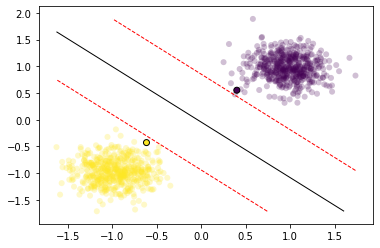

In [60]:
fig, ax = plt.subplots()
grid, ax = plot_decision_boundary(output_blobs, ax)

In [61]:
#Reading the dataset
import pandas as pd
train_data = pd.read_csv("SVM_data.txt")

In [62]:
train_data.head(10)

,c1,c2,label
0,243,3,-1
1,116,165,1
2,198,127,-1
3,184,234,1
4,165,231,1
5,160,46,-1
6,70,169,1
7,300,94,-1
8,95,62,-1
9,61,186,1


In [63]:
#Splitting data as X and Y
X_train = train_data.iloc[:,:-1]
Y_train = train_data.iloc[:,-1]

In [64]:
#Scale data to be centered at origin with Unit Standard Deviation 
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train, Y_train)

In [65]:
#Instantiating the model with Hard Margin
C = 1000.0
m = len(X_train_scaled)
initial_alpha = np.zeros(m)
initial_b = 0

# Set tolerances
tol = 0.01 # error tolerance
eps = 0.01 # alpha tolerance

# Instantiate model
model = SMO(X_train_scaled, Y_train, C, kernel,
                 initial_alpha, initial_b, np.zeros(m))

In [66]:
# Initialize error cache
initial_error = decision(model.alpha, model.y, model.kernel,
                                  model.X, model.X, model.b) - model.y
model.errors = initial_error

In [67]:
#Train the model
np.random.seed(0)
output = train(model)

C:\Users\bnama\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:56: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  return getattr(obj, method)(*args, **kwds)
C:\Users\bnama\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:56: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return getattr(obj, method)(*args, **kwds)


In [68]:
#Plot the decision boundary to generate the classification labels

def plot_decision_boundary(model, ax, resolution=100, colors=('r', 'k', 'r'), levels=(-1, 0, 1)):
        xrange = np.linspace(model.X[:,0].min(), model.X[:,0].max(), resolution)
        yrange = np.linspace(model.X[:,1].min(), model.X[:,1].max(), resolution)
        grid = [[decision(model.alpha, model.y,
                                   model.kernel, model.X,
                                   np.array([xr, yr]), model.b) for xr in xrange] for yr in yrange]
        grid = np.array(grid).reshape(len(xrange), len(yrange))
        
        
        ax.contour(xrange, yrange, grid, levels=levels, linewidths=(1, 1, 1),
                   linestyles=('--', '-', '--'), colors=colors)
        ax.scatter(model.X[:,0], model.X[:,1],
                   c=model.y, cmap=plt.cm.viridis, lw=0, alpha=0.25)
        
        mask = np.round(model.alpha, decimals=2) != 0.0
        ax.scatter(model.X[mask,0], model.X[mask,1],
                   c=model.y[mask], cmap=plt.cm.viridis, lw=1, edgecolors='k')
        
        return grid, ax

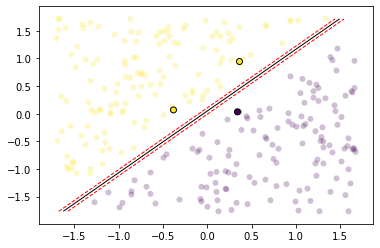

In [69]:
fig, ax = plt.subplots()
grid, ax = plot_decision_boundary(output, ax)